In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import heapq
import cv2
import os
import kagglehub


In [2]:
# DCT function (2D)
def dct2(block):
    return cv2.dct(np.float32(block))

# Inverse DCT function (2D)
def idct2(block):
    return cv2.idct(np.float32(block))


In [3]:
# Node class for Huffman tree
class Node:
    def __init__(self, symbol, freq):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq


In [4]:
# Build Huffman tree from frequencies
def build_huffman_tree(freqs):
    heap = [Node(sym, f) for sym, f in freqs.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        n1 = heapq.heappop(heap)
        n2 = heapq.heappop(heap)
        merged = Node(None, n1.freq + n2.freq)
        merged.left, merged.right = n1, n2
        heapq.heappush(heap, merged)
    return heap[0]

# Generate Huffman codes
def make_codes(node, prefix="", codebook={}):
    if node is None:
        return
    if node.symbol is not None:
        codebook[node.symbol] = prefix
    make_codes(node.left, prefix + "0", codebook)
    make_codes(node.right, prefix + "1", codebook)
    return codebook

# Huffman encode data
def huffman_encode(data):
    freqs = Counter(data)
    tree = build_huffman_tree(freqs)
    codes = make_codes(tree, "", {})
    encoded = "".join([codes[val] for val in data])
    return encoded, codes


In [5]:
# Compress single image using DCT + Huffman
def compress_image(img_path):
    # Read original image
    img = cv2.imread(img_path)

    # Convert BGR → YCrCb
    ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    Y, Cr, Cb = cv2.split(ycrcb)

    # Shift and DCT on Y channel
    Y_shifted = np.float32(Y) - 128
    dct_Y = dct2(Y_shifted)

    # Quantization
    Q = np.ones_like(dct_Y) * 20
    quantized = np.round(dct_Y / Q)

    # Huffman encoding
    flat = quantized.flatten().astype(int).tolist()
    encoded, codes = huffman_encode(flat)
    comp_size = len(encoded) / 8  # bits to bytes

    # Dequantize and IDCT
    dequantized = quantized * Q
    rec_Y = idct2(dequantized) + 128
    rec_Y = np.clip(rec_Y, 0, 255).astype(np.uint8)

    # Merge reconstructed Y with original Cr, Cb
    rec_img_ycrcb = cv2.merge([rec_Y, Cr, Cb])
    rec_img = cv2.cvtColor(rec_img_ycrcb, cv2.COLOR_YCrCb2BGR)

    # Calculate compression ratio
    orig_size = Y.size
    ratio = orig_size / comp_size

    return ratio, rec_img, orig_size, comp_size


In [6]:
# Load dataset from Kaggle (bulentsiyah)
def load_dataset():
    dataset_path = kagglehub.dataset_download("bulentsiyah/opencv-samples-images")
    print("Dataset downloaded at:", dataset_path)
    return dataset_path


In [7]:
# Compress and display results for a range of images
def display_dataset_results(dataset_path, start_index=0, end_index=5):
    all_images = []

    # Collect all image file paths
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith((".jpg", ".png", ".jpeg")):
                all_images.append(os.path.join(root, file))

    all_images.sort()
    total = len(all_images)
    print(f"Total images found: {total}")

    # Adjust range
    start_index = max(0, start_index)
    end_index = min(end_index, total)

    if start_index >= end_index:
        print("No images to display.")
        return

    print(f"Displaying images {start_index} to {end_index - 1}...\n")

    for idx in range(start_index, end_index):
        img_path = all_images[idx]
        file = os.path.basename(img_path)

        try:
            # Read original and resize for display
            orig = cv2.imread(img_path)
            orig = cv2.resize(orig, (256, 256))

            # Convert to YCbCr for reference display
            ycbcr_img = cv2.cvtColor(orig, cv2.COLOR_BGR2YCrCb)

            # Compress image
            ratio, recon_bgr, orig_size, comp_size = compress_image(img_path)

            # Resize reconstructed image for consistency
            recon_bgr = cv2.resize(recon_bgr, (256, 256))

            # Print compression details
            print(f"{file} - Orig: {orig_size} bytes | Comp: {comp_size:.2f} bytes | Ratio: {ratio:.2f}")

            # Display images
            plt.figure(figsize=(12, 4))
            plt.suptitle(f"{file}\nOriginal: {orig_size/1024:.2f} KB | Compressed: {comp_size/1024:.2f} KB")

            plt.subplot(1, 3, 1)
            plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
            plt.title("Original")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(cv2.cvtColor(ycbcr_img, cv2.COLOR_YCrCb2RGB))
            plt.title("YCbCr")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(cv2.cvtColor(recon_bgr, cv2.COLOR_BGR2RGB))
            plt.title("Compressed")
            plt.axis("off")

            plt.show()

        except Exception as e:
            print(f"Error processing {file}: {e}")


Using Colab cache for faster access to the 'opencv-samples-images' dataset.
Dataset downloaded at: /kaggle/input/opencv-samples-images
Total images found: 84
Displaying images 0 to 4...

Background_Subtraction_Tutorial_frame.png - Orig: 442368 bytes | Comp: 88781.62 bytes | Ratio: 4.98


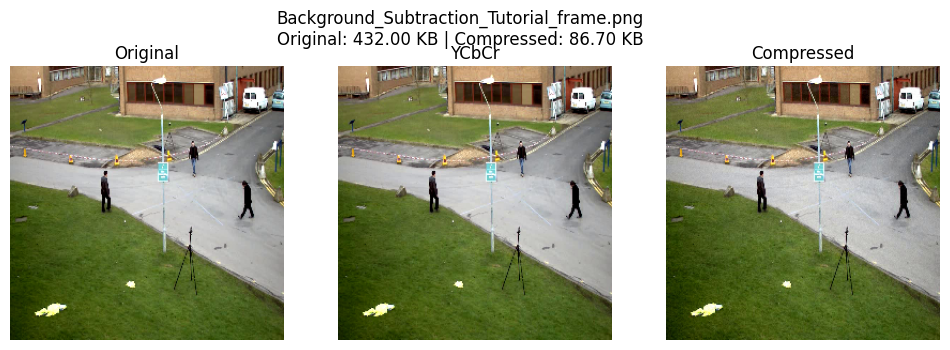

Background_Subtraction_Tutorial_frame_1.png - Orig: 442368 bytes | Comp: 89440.50 bytes | Ratio: 4.95


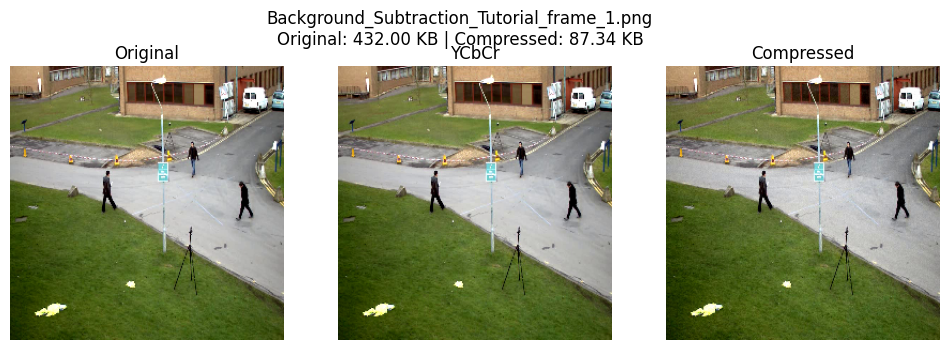

Origin_of_Species.jpg - Orig: 647100 bytes | Comp: 148589.50 bytes | Ratio: 4.35


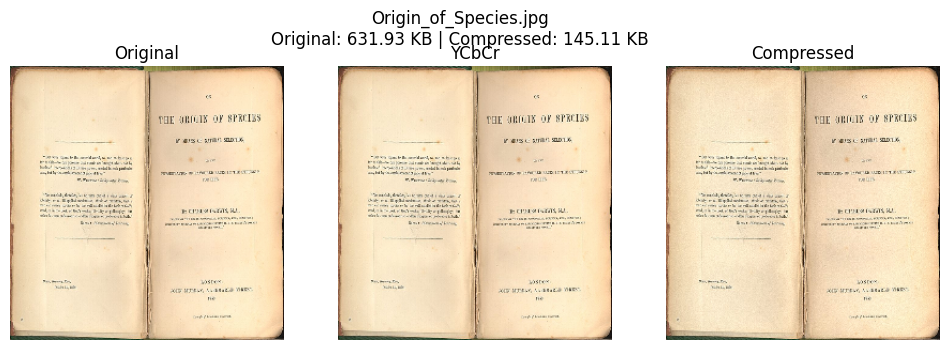

WaldoBeach.jpg - Orig: 786432 bytes | Comp: 289696.00 bytes | Ratio: 2.71


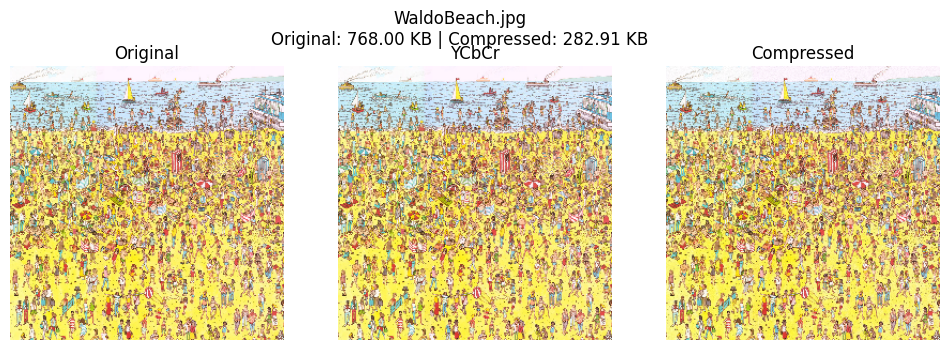

blobs.jpg - Orig: 338886 bytes | Comp: 80811.62 bytes | Ratio: 4.19


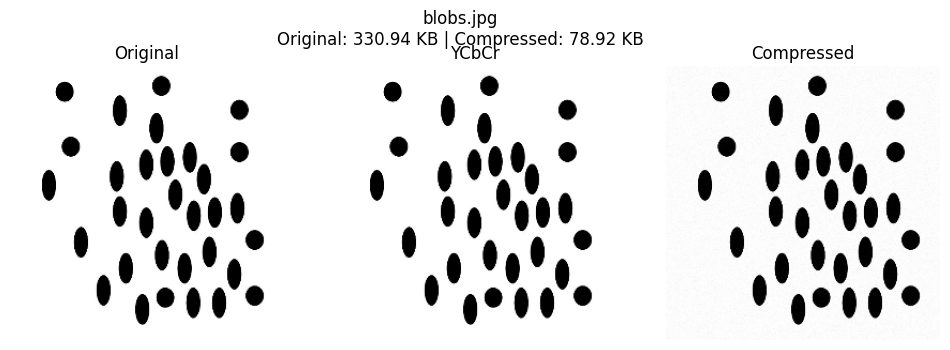

In [8]:
# Run dataset download and compression display
dataset_path = load_dataset()
display_dataset_results(dataset_path, start_index=0, end_index=5)
